# Stock prediction with ARIMA and RNNs

# Load data

In [2]:
import pandas as pd

df = pd.read_csv('new_stock_data.csv')
df['Date'] = pd.to_datetime(df['Date'])

AAPL_df = df[df['Code']=='AAPL'].reset_index(drop=True)
COST_df = df[df['Code']=='COST'].reset_index(drop=True)
KO_df = df[df['Code']=='KO'].reset_index(drop=True)
TSLA_df = df[df['Code']=='TSLA'].reset_index(drop=True)

AAPL_df['Change'] = AAPL_df['Close'].diff()
AAPL_df = AAPL_df.dropna() # Remove nan values
COST_df['Change'] = COST_df['Close'].diff()
COST_df = COST_df.dropna() # Remove nan values
KO_df['Change'] = KO_df['Close'].diff()
KO_df = KO_df.dropna() # Remove nan values
TSLA_df['Change'] = TSLA_df['Close'].diff()
TSLA_df = TSLA_df.dropna() # Remove nan values

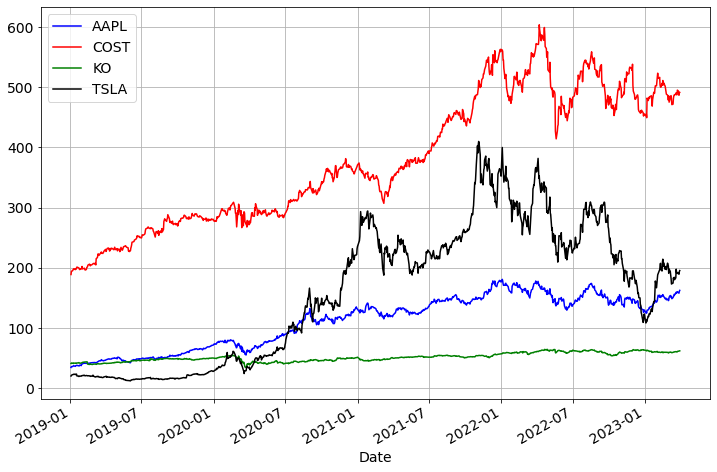

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from pylab import rcParams

rcParams['figure.figsize'] = 12, 8 # width 12, height 8
mpl.rcParams.update({'font.size': 14})

ax = plt.subplot()
AAPL_df.plot(x='Date',y='Close', ax=ax, style='b', grid=True, label='AAPL')
COST_df.plot(x='Date',y='Close', ax=ax, style='r', grid=True, label='COST')
KO_df.plot(x='Date',y='Close', ax=ax, style='g', grid=True, label='KO')
TSLA_df.plot(x='Date',y='Close', ax=ax, style='black', grid=True, label='TSLA')
plt.legend()
plt.show()

In [4]:
AAPL_df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Change
count,1068.000000,1068.000000,1068.000000,1068.000000,1.068000e+03,1068.000000,1068.000000,1068.000000
mean,111.581963,112.973588,110.283460,111.693352,1.095981e+08,0.003345,0.003745,0.116398
std,43.056344,43.592584,42.510314,43.065374,5.273269e+07,0.026386,0.122398,2.417521
min,34.688538,35.107751,34.211506,34.257282,3.519590e+07,0.000000,0.000000,-10.361443
25%,67.735311,68.737601,66.702559,67.638329,7.579752e+07,0.000000,0.000000,-0.922436
50%,125.232088,126.430099,123.856663,124.854362,9.477995e+07,0.000000,0.000000,0.145512
75%,147.351856,148.636229,145.771799,147.558758,1.262177e+08,0.000000,0.000000,1.288029
max,181.299346,181.607085,177.814910,180.683853,4.265100e+08,0.230000,4.000000,11.981705


From the boxplot, we can find there is no outlier in stock prices. 

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Open'),
  Text(1, 0, 'High'),
  Text(2, 0, 'Low'),
  Text(3, 0, 'Close')])

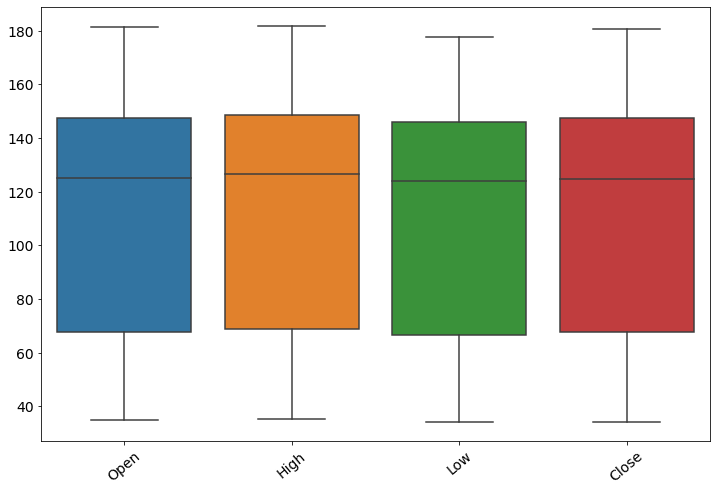

In [28]:
fig,ax = plt.subplots()
sns.boxplot(data=AAPL_df[['Open','High','Low','Close']],ax=ax)
plt.xticks(rotation=40)

# Implementation

## Univariate Time Series Analysis of AAPL

In [5]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import numpy as np
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# the function that form sequence data
def create_sequence_data(df, features, responses, sequence_length):
    feature_sc = MinMaxScaler() # normalisation
    close_sc = MinMaxScaler() # normalisation
    data_feature = feature_sc.fit_transform(df.loc[:,features])
    data_response = close_sc.fit_transform(np.array(df.loc[:,responses])).ravel()

    # split dataset into train dataset, validation dataset and test dataset
    N = data_feature.shape[0]
    data_X = []
    data_y = []

    for i in range(N-sequence_length):
        data_X.append(data_feature[i:(i+sequence_length)])
        data_y.append(data_response[i+sequence_length])

    data_X = np.array(data_X)
    data_y = np.array(data_y)
    print('data_X.shape',data_X.shape,'data_y.shape',data_y.shape)
    
    indexs = list(range(sequence_length,N))
    train_length = math.floor(len(indexs)*0.7)
    val_length = math.floor(len(indexs)*0.2)
    test_length = len(indexs)-val_length-train_length
    print('train_length',train_length,'validation_length',val_length,'test_length',test_length)
    
    train_indexs,val_indexs,test_indexs = np.array(indexs)[:train_length],np.array(indexs)[train_length:(train_length+val_length)],np.array(indexs)[(train_length+val_length):]
    print('train_indexs.shape',train_indexs.shape,'val_indexs.shape',val_indexs.shape,'test_indexs.shape',test_indexs.shape)
    
    train_X,train_y = data_X[:train_length,:,:],data_y[:train_length]
    val_X,val_y = data_X[train_length:(train_length+val_length),:,:],data_y[train_length:(train_length+val_length)]
    test_X,test_y = data_X[(train_length+val_length):,:,:],data_y[(train_length+val_length):]
    print('train_X.shape',train_X.shape,'train_y.shape',train_y.shape,'val_X.shape',val_X.shape,'val_y.shape',val_y.shape,'test_X.shape',test_X.shape,'test_y.shape',test_y.shape)
    
    return train_X, train_y, val_X, val_y, test_X, test_y, train_indexs, val_indexs, test_indexs, close_sc

# Dataset
class Time_Sequence_Dataset(Dataset):
    def __init__(self, data, label):
        self.data = torch.tensor(data,dtype=torch.float32)
        self.label = torch.tensor(label,dtype=torch.float32)
        
    def __getitem__(self, index):
        return self.data[index].to(device), self.label[index].to(device)

    def __len__(self):
        return self.data.size(0)

# RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        return out

# GRU model
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.gru(x, h0)
        out = self.fc(out)
        return out

# LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))  # batch_size, seq_length, hidden_size
        out = self.fc(out)
        return out

# model train function    
def model_train(model,train_loader,learning_rate,num_epochs):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (seq, labels) in enumerate(train_loader):
            seq = seq.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(seq)
            outputs = outputs.reshape(outputs.shape[0],outputs.shape[1])
            loss = torch.pow(outputs-labels.reshape(outputs.shape[0],1),2).mean(axis=1).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    return model

# model test function    
def model_test(model,test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for seq, labels in test_loader:
            seq = seq.to(device)
            labels = labels.to(device)
            outputs = model(seq)
    return outputs

### RNN model

#### Hyperparameter selection

In [13]:
features = ['Close']
responses = ['Close']

for sequence_length in [3,5,10]:
    for batch_size in [32,64,128]:
        for lr in [0.001,0.0001]:
            train_X, train_y, val_X, val_y, test_X, test_y, train_indexs, val_indexs, test_indexs, close_sc = create_sequence_data(AAPL_df, features, responses, sequence_length)
            dataset = Time_Sequence_Dataset(train_X, train_y)
            train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
            val_dataset = Time_Sequence_Dataset(val_X,val_y)
            val_loader = DataLoader(val_dataset, batch_size=val_X.shape[0], shuffle=False)
            test_dataset = Time_Sequence_Dataset(test_X,test_y)
            test_loader = DataLoader(test_dataset, batch_size=test_X.shape[0], shuffle=False)
            
            input_size = len(features)
            hidden_size = 128
            num_layers = 2
            output_size = 1

            num_epochs = 50
            learning_rate = lr

            tmp_model = RNN(input_size, hidden_size, num_layers, output_size).to(device)
            tmp_model = model_train(tmp_model,train_loader,learning_rate,num_epochs)
            val_outputs = model_test(tmp_model,val_loader)
            
            y_pred_val = val_outputs.reshape(val_outputs.shape[0],val_outputs.shape[1]).mean(axis=1,keepdim=True).numpy()
            y_pred_val = close_sc.inverse_transform(y_pred_val)
            close_true_val = AAPL_df.loc[val_indexs,'Close'].to_numpy()
            close_pred_val = y_pred_val.ravel()  # use 'Close' as feature

            print('[Sequence length: %d, batch size: %d, learning rate: %f], the MSE of val dataset is equal to %f'%(sequence_length,batch_size,learning_rate,mean_squared_error(close_true_val,close_pred_val)))


data_X.shape (1065, 3, 1) data_y.shape (1065,)
train_length 745 validation_length 213 test_length 107
train_indexs.shape (745,) val_indexs.shape (213,) test_indexs.shape (107,)
train_X.shape (745, 3, 1) train_y.shape (745,) val_X.shape (213, 3, 1) val_y.shape (213,) test_X.shape (107, 3, 1) test_y.shape (107,)
Epoch [10/50], Step [24/24], Loss: 0.0003
Epoch [20/50], Step [24/24], Loss: 0.0003
Epoch [30/50], Step [24/24], Loss: 0.0004
Epoch [40/50], Step [24/24], Loss: 0.0003
Epoch [50/50], Step [24/24], Loss: 0.0003
[Sequence length: 3, batch size: 32, learning rate: 0.001000], the MSE of val dataset is equal to 6.492734
data_X.shape (1065, 3, 1) data_y.shape (1065,)
train_length 745 validation_length 213 test_length 107
train_indexs.shape (745,) val_indexs.shape (213,) test_indexs.shape (107,)
train_X.shape (745, 3, 1) train_y.shape (745,) val_X.shape (213, 3, 1) val_y.shape (213,) test_X.shape (107, 3, 1) test_y.shape (107,)
Epoch [10/50], Step [24/24], Loss: 0.0062
Epoch [20/50], St

In [14]:
features = ['Close']
responses = ['Close']
sequence_length = 3
batch_size = 128

# create dataloader
train_X, train_y, val_X, val_y, test_X, test_y, train_indexs, val_indexs, test_indexs, close_sc = create_sequence_data(AAPL_df, features, responses, sequence_length)
dataset = Time_Sequence_Dataset(train_X, train_y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_dataset = Time_Sequence_Dataset(val_X,val_y)
val_loader = DataLoader(val_dataset, batch_size=val_X.shape[0], shuffle=False)
test_dataset = Time_Sequence_Dataset(test_X,test_y)
test_loader = DataLoader(test_dataset, batch_size=test_X.shape[0], shuffle=False)

# initialise RNN model
input_size = len(features)
hidden_size = 128
num_layers = 2
output_size = 1

num_epochs = 50
learning_rate = 0.001

model = RNN(input_size, hidden_size, num_layers, output_size).to(device)
model = model_train(model,train_loader,learning_rate,num_epochs)
val_outputs = model_test(model,val_loader)
outputs = model_test(model,test_loader)

data_X.shape (1065, 3, 1) data_y.shape (1065,)
train_length 745 validation_length 213 test_length 107
train_indexs.shape (745,) val_indexs.shape (213,) test_indexs.shape (107,)
train_X.shape (745, 3, 1) train_y.shape (745,) val_X.shape (213, 3, 1) val_y.shape (213,) test_X.shape (107, 3, 1) test_y.shape (107,)
Epoch [10/50], Step [6/6], Loss: 0.0036
Epoch [20/50], Step [6/6], Loss: 0.0003
Epoch [30/50], Step [6/6], Loss: 0.0003
Epoch [40/50], Step [6/6], Loss: 0.0004
Epoch [50/50], Step [6/6], Loss: 0.0004


In [15]:
y_pred_val = val_outputs.reshape(val_outputs.shape[0],val_outputs.shape[1]).mean(axis=1,keepdim=True).numpy()
y_pred_val = close_sc.inverse_transform(y_pred_val)
close_true_val = AAPL_df.loc[val_indexs,'Close'].to_numpy()
close_pred_val = y_pred_val.ravel()  # use 'Close' as feature

print('The MSE of val dataset is equal to %f'%(mean_squared_error(close_true_val,close_pred_val)))

The MSE of val dataset is equal to 6.624863


In [16]:
y_pred = outputs.reshape(outputs.shape[0],outputs.shape[1]).mean(axis=1,keepdim=True).numpy()
y_pred = close_sc.inverse_transform(y_pred)
close_true = AAPL_df.loc[test_indexs,'Close'].to_numpy()
#close_pred = AAPL_df.loc[test_indexs-1,'Close'].to_numpy()+y_pred.ravel()  # use 'Change' as feature
close_pred = y_pred.ravel()  # use 'Close' as feature

print('The MSE of test dataset is equal to %f'%(mean_squared_error(close_true,close_pred))) # MSE
print('The RMSE of test dataset is equal to %f'%(math.sqrt(mean_squared_error(close_true,close_pred)))) # RMSE
print('The MAE of test dataset is equal to %f'%(mean_absolute_error(close_true,close_pred))) # MAE
print('The R squared of test dataset is equal to %f'%(r2_score(close_true,close_pred))) # R squared

The MSE of test dataset is equal to 5.903069
The RMSE of test dataset is equal to 2.429623
The MAE of test dataset is equal to 1.866095
The R squared of test dataset is equal to 0.925219


### GRU model

#### Hyperparameter selection

In [17]:
features = ['Close']
responses = ['Close']

for sequence_length in [3,5,10]:
    for batch_size in [32,64,128]:
        for lr in [0.001,0.0001]:
            train_X, train_y, val_X, val_y, test_X, test_y, train_indexs, val_indexs, test_indexs, close_sc = create_sequence_data(AAPL_df, features, responses, sequence_length)
            dataset = Time_Sequence_Dataset(train_X, train_y)
            train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
            val_dataset = Time_Sequence_Dataset(val_X,val_y)
            val_loader = DataLoader(val_dataset, batch_size=val_X.shape[0], shuffle=False)
            test_dataset = Time_Sequence_Dataset(test_X,test_y)
            test_loader = DataLoader(test_dataset, batch_size=test_X.shape[0], shuffle=False)
            
            input_size = len(features)
            hidden_size = 128
            num_layers = 2
            output_size = 1

            num_epochs = 50
            learning_rate = lr

            tmp_model = GRU(input_size, hidden_size, num_layers, output_size).to(device)
            tmp_model = model_train(tmp_model,train_loader,learning_rate,num_epochs)
            val_outputs = model_test(tmp_model,val_loader)
            
            y_pred_val = val_outputs.reshape(val_outputs.shape[0],val_outputs.shape[1]).mean(axis=1,keepdim=True).numpy()
            y_pred_val = close_sc.inverse_transform(y_pred_val)
            close_true_val = AAPL_df.loc[val_indexs,'Close'].to_numpy()
            close_pred_val = y_pred_val.ravel()  # use 'Close' as feature

            print('[Sequence length: %d, batch size: %d, learning rate: %f], the MSE of val dataset is equal to %f'%(sequence_length,batch_size,learning_rate,mean_squared_error(close_true_val,close_pred_val)))


data_X.shape (1065, 3, 1) data_y.shape (1065,)
train_length 745 validation_length 213 test_length 107
train_indexs.shape (745,) val_indexs.shape (213,) test_indexs.shape (107,)
train_X.shape (745, 3, 1) train_y.shape (745,) val_X.shape (213, 3, 1) val_y.shape (213,) test_X.shape (107, 3, 1) test_y.shape (107,)
Epoch [10/50], Step [24/24], Loss: 0.0005
Epoch [20/50], Step [24/24], Loss: 0.0001
Epoch [30/50], Step [24/24], Loss: 0.0003
Epoch [40/50], Step [24/24], Loss: 0.0007
Epoch [50/50], Step [24/24], Loss: 0.0007
[Sequence length: 3, batch size: 32, learning rate: 0.001000], the MSE of val dataset is equal to 8.944299
data_X.shape (1065, 3, 1) data_y.shape (1065,)
train_length 745 validation_length 213 test_length 107
train_indexs.shape (745,) val_indexs.shape (213,) test_indexs.shape (107,)
train_X.shape (745, 3, 1) train_y.shape (745,) val_X.shape (213, 3, 1) val_y.shape (213,) test_X.shape (107, 3, 1) test_y.shape (107,)
Epoch [10/50], Step [24/24], Loss: 0.0444
Epoch [20/50], St

In [18]:
features = ['Close']
responses = ['Close']
sequence_length = 3
batch_size = 128

# create dataloader
train_X, train_y, val_X, val_y, test_X, test_y, train_indexs, val_indexs, test_indexs, close_sc = create_sequence_data(AAPL_df, features, responses, sequence_length)
dataset = Time_Sequence_Dataset(train_X, train_y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_dataset = Time_Sequence_Dataset(val_X,val_y)
val_loader = DataLoader(val_dataset, batch_size=val_X.shape[0], shuffle=False)
test_dataset = Time_Sequence_Dataset(test_X,test_y)
test_loader = DataLoader(test_dataset, batch_size=test_X.shape[0], shuffle=False)

# initialise the GRU model
input_size = len(features)
hidden_size = 128
num_layers = 2
output_size = 1

num_epochs = 50
learning_rate = 0.001

model = GRU(input_size, hidden_size, num_layers, output_size).to(device)
model = model_train(model,train_loader,learning_rate,num_epochs)
outputs = model_test(model,test_loader)

data_X.shape (1065, 3, 1) data_y.shape (1065,)
train_length 745 validation_length 213 test_length 107
train_indexs.shape (745,) val_indexs.shape (213,) test_indexs.shape (107,)
train_X.shape (745, 3, 1) train_y.shape (745,) val_X.shape (213, 3, 1) val_y.shape (213,) test_X.shape (107, 3, 1) test_y.shape (107,)
Epoch [10/50], Step [6/6], Loss: 0.0092
Epoch [20/50], Step [6/6], Loss: 0.0013
Epoch [30/50], Step [6/6], Loss: 0.0004
Epoch [40/50], Step [6/6], Loss: 0.0004
Epoch [50/50], Step [6/6], Loss: 0.0003


In [19]:
y_pred = outputs.reshape(outputs.shape[0],outputs.shape[1]).mean(axis=1,keepdim=True).numpy()
y_pred = close_sc.inverse_transform(y_pred)
close_true = AAPL_df.loc[test_indexs,'Close'].to_numpy()
#close_pred = AAPL_df.loc[test_indexs-1,'Close'].to_numpy()+y_pred.ravel()  # use 'Change' as feature
close_pred = y_pred.ravel()  # use 'Close' as feature

print('The MSE of test dataset is equal to %f'%(mean_squared_error(close_true,close_pred))) # MSE
print('The RMSE of test dataset is equal to %f'%(math.sqrt(mean_squared_error(close_true,close_pred)))) # RMSE
print('The MAE of test dataset is equal to %f'%(mean_absolute_error(close_true,close_pred))) # MAE
print('The R squared of test dataset is equal to %f'%(r2_score(close_true,close_pred))) # R squared

The MSE of test dataset is equal to 5.931490
The RMSE of test dataset is equal to 2.435465
The MAE of test dataset is equal to 1.871441
The R squared of test dataset is equal to 0.924859


### LSTM model

#### Hyperparameter selection

In [20]:
features = ['Close']
responses = ['Close']

for sequence_length in [3,5,10]:
    for batch_size in [32,64,128]:
        for lr in [0.001,0.0001]:
            train_X, train_y, val_X, val_y, test_X, test_y, train_indexs, val_indexs, test_indexs, close_sc = create_sequence_data(AAPL_df, features, responses, sequence_length)
            dataset = Time_Sequence_Dataset(train_X, train_y)
            train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
            val_dataset = Time_Sequence_Dataset(val_X,val_y)
            val_loader = DataLoader(val_dataset, batch_size=val_X.shape[0], shuffle=False)
            test_dataset = Time_Sequence_Dataset(test_X,test_y)
            test_loader = DataLoader(test_dataset, batch_size=test_X.shape[0], shuffle=False)
            
            input_size = len(features)
            hidden_size = 128
            num_layers = 2
            output_size = 1

            num_epochs = 50
            learning_rate = lr

            tmp_model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
            tmp_model = model_train(tmp_model,train_loader,learning_rate,num_epochs)
            val_outputs = model_test(tmp_model,val_loader)
            
            y_pred_val = val_outputs.reshape(val_outputs.shape[0],val_outputs.shape[1]).mean(axis=1,keepdim=True).numpy()
            y_pred_val = close_sc.inverse_transform(y_pred_val)
            close_true_val = AAPL_df.loc[val_indexs,'Close'].to_numpy()
            close_pred_val = y_pred_val.ravel()  # use 'Close' as feature

            print('[Sequence length: %d, batch size: %d, learning rate: %f], the MSE of val dataset is equal to %f'%(sequence_length,batch_size,learning_rate,mean_squared_error(close_true_val,close_pred_val)))


data_X.shape (1065, 3, 1) data_y.shape (1065,)
train_length 745 validation_length 213 test_length 107
train_indexs.shape (745,) val_indexs.shape (213,) test_indexs.shape (107,)
train_X.shape (745, 3, 1) train_y.shape (745,) val_X.shape (213, 3, 1) val_y.shape (213,) test_X.shape (107, 3, 1) test_y.shape (107,)
Epoch [10/50], Step [24/24], Loss: 0.0005
Epoch [20/50], Step [24/24], Loss: 0.0003
Epoch [30/50], Step [24/24], Loss: 0.0006
Epoch [40/50], Step [24/24], Loss: 0.0004
Epoch [50/50], Step [24/24], Loss: 0.0002
[Sequence length: 3, batch size: 32, learning rate: 0.001000], the MSE of val dataset is equal to 17.719807
data_X.shape (1065, 3, 1) data_y.shape (1065,)
train_length 745 validation_length 213 test_length 107
train_indexs.shape (745,) val_indexs.shape (213,) test_indexs.shape (107,)
train_X.shape (745, 3, 1) train_y.shape (745,) val_X.shape (213, 3, 1) val_y.shape (213,) test_X.shape (107, 3, 1) test_y.shape (107,)
Epoch [10/50], Step [24/24], Loss: 0.0590
Epoch [20/50], S

In [21]:
features = ['Close']
responses = ['Close']
sequence_length = 3
batch_size = 128

# create dataloader
train_X, train_y, val_X, val_y, test_X, test_y, train_indexs, val_indexs, test_indexs, close_sc = create_sequence_data(AAPL_df, features, responses, sequence_length)
dataset = Time_Sequence_Dataset(train_X, train_y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_dataset = Time_Sequence_Dataset(val_X,val_y)
val_loader = DataLoader(val_dataset, batch_size=val_X.shape[0], shuffle=False)
test_dataset = Time_Sequence_Dataset(test_X,test_y)
test_loader = DataLoader(test_dataset, batch_size=test_X.shape[0], shuffle=False)

# initialise LSTM model
input_size = len(features)
hidden_size = 128
num_layers = 2
output_size = 1

num_epochs = 50
learning_rate = 0.001

model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
model = model_train(model,train_loader,learning_rate,num_epochs)
outputs = model_test(model,test_loader)

data_X.shape (1065, 3, 1) data_y.shape (1065,)
train_length 745 validation_length 213 test_length 107
train_indexs.shape (745,) val_indexs.shape (213,) test_indexs.shape (107,)
train_X.shape (745, 3, 1) train_y.shape (745,) val_X.shape (213, 3, 1) val_y.shape (213,) test_X.shape (107, 3, 1) test_y.shape (107,)
Epoch [10/50], Step [6/6], Loss: 0.0572
Epoch [20/50], Step [6/6], Loss: 0.0161
Epoch [30/50], Step [6/6], Loss: 0.0064
Epoch [40/50], Step [6/6], Loss: 0.0013
Epoch [50/50], Step [6/6], Loss: 0.0004


In [22]:
y_pred = outputs.reshape(outputs.shape[0],outputs.shape[1]).mean(axis=1,keepdim=True).numpy()
y_pred = close_sc.inverse_transform(y_pred)
close_true = AAPL_df.loc[test_indexs,'Close'].to_numpy()
#close_pred = AAPL_df.loc[test_indexs-1,'Close'].to_numpy()+y_pred.ravel()  # use 'Change' as feature
close_pred = y_pred.ravel()  # use 'Close' as feature

print('The MSE of test dataset is equal to %f'%(mean_squared_error(close_true,close_pred))) # MSE
print('The RMSE of test dataset is equal to %f'%(math.sqrt(mean_squared_error(close_true,close_pred)))) # RMSE
print('The MAE of test dataset is equal to %f'%(mean_absolute_error(close_true,close_pred))) # MAE
print('The R squared of test dataset is equal to %f'%(r2_score(close_true,close_pred))) # R squared

The MSE of test dataset is equal to 5.253628
The RMSE of test dataset is equal to 2.292079
The MAE of test dataset is equal to 1.766630
The R squared of test dataset is equal to 0.933447


### ARIMA

In [24]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

closing_prices = AAPL_df['Close']
N = 100
length = len(closing_prices)
true_values, predicted_values = [], []
for kk in range(0,length-N-1,1):
    train_data = closing_prices.iloc[kk:kk+N]
    test_data = closing_prices.iloc[kk+N:kk+N+1]
    model = ARIMA(train_data, order=(5, 1, 0))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1)
    
    predicted_value = forecast.iloc[0]
    true_value = test_data.iloc[0]
    predicted_values.append(predicted_value)
    true_values.append(true_value)

In [25]:
print('The MSE of test dataset is equal to %f'%(mean_squared_error(true_values,predicted_values))) # MSE
print('The RMSE of test dataset is equal to %f'%(math.sqrt(mean_squared_error(true_values,predicted_values)))) # RMSE
print('The MAE of test dataset is equal to %f'%(mean_absolute_error(true_values,predicted_values))) # MAE
print('The R squared of test dataset is equal to %f'%(r2_score(true_values,predicted_values))) # R squared

The MSE of test dataset is equal to 6.900502
The RMSE of test dataset is equal to 2.626881
The MAE of test dataset is equal to 1.886315
The R squared of test dataset is equal to 0.995446


In [26]:
# evaluate the result of each model
results1 = pd.DataFrame([[5.903069,5.931490,5.253628,6.900502],[2.429623,2.435465,2.292079,2.626881],\
                        [1.866095,1.871441,1.766630,1.886315],[0.925219,0.924859,0.933447,0.995446],],\
                       index=['MSE','RMSE','MAE','R square'], columns=['RNN','GRU','LSTM','ARIMA'])
results1.T

,MSE,RMSE,MAE,R square
RNN,5.903069,2.429623,1.866095,0.925219
GRU,5.931490,2.435465,1.871441,0.924859
LSTM,5.253628,2.292079,1.766630,0.933447
ARIMA,6.900502,2.626881,1.886315,0.995446


## Multivariate Time Series Analysis of AAPL

### RNN model

#### Hyperparameter selection

In [6]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Change']
responses = ['Close']

for sequence_length in [3,5,10]:
    for batch_size in [32,64,128]:
        for lr in [0.001,0.0001]:
            train_X, train_y, val_X, val_y, test_X, test_y, train_indexs, val_indexs, test_indexs, close_sc = create_sequence_data(AAPL_df, features, responses, sequence_length)
            dataset = Time_Sequence_Dataset(train_X, train_y)
            train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
            val_dataset = Time_Sequence_Dataset(val_X,val_y)
            val_loader = DataLoader(val_dataset, batch_size=val_X.shape[0], shuffle=False)
            test_dataset = Time_Sequence_Dataset(test_X,test_y)
            test_loader = DataLoader(test_dataset, batch_size=test_X.shape[0], shuffle=False)
            
            input_size = len(features)
            hidden_size = 128
            num_layers = 2
            output_size = 1

            num_epochs = 50
            learning_rate = lr

            tmp_model = RNN(input_size, hidden_size, num_layers, output_size).to(device)
            tmp_model = model_train(tmp_model,train_loader,learning_rate,num_epochs)
            val_outputs = model_test(tmp_model,val_loader)
            
            y_pred_val = val_outputs.reshape(val_outputs.shape[0],val_outputs.shape[1]).mean(axis=1,keepdim=True).numpy()
            y_pred_val = close_sc.inverse_transform(y_pred_val)
            close_true_val = AAPL_df.loc[val_indexs,'Close'].to_numpy()
            close_pred_val = y_pred_val.ravel()  # use 'Close' as feature

            print('[Sequence length: %d, batch size: %d, learning rate: %f], the MSE of val dataset is equal to %f'%(sequence_length,batch_size,learning_rate,mean_squared_error(close_true_val,close_pred_val)))


data_X.shape (1065, 3, 6) data_y.shape (1065,)
train_length 745 validation_length 213 test_length 107
train_indexs.shape (745,) val_indexs.shape (213,) test_indexs.shape (107,)
train_X.shape (745, 3, 6) train_y.shape (745,) val_X.shape (213, 3, 6) val_y.shape (213,) test_X.shape (107, 3, 6) test_y.shape (107,)
Epoch [10/50], Step [24/24], Loss: 0.0006
Epoch [20/50], Step [24/24], Loss: 0.0001
Epoch [30/50], Step [24/24], Loss: 0.0001
Epoch [40/50], Step [24/24], Loss: 0.0013
Epoch [50/50], Step [24/24], Loss: 0.0002
[Sequence length: 3, batch size: 32, learning rate: 0.001000], the MSE of val dataset is equal to 11.088254
data_X.shape (1065, 3, 6) data_y.shape (1065,)
train_length 745 validation_length 213 test_length 107
train_indexs.shape (745,) val_indexs.shape (213,) test_indexs.shape (107,)
train_X.shape (745, 3, 6) train_y.shape (745,) val_X.shape (213, 3, 6) val_y.shape (213,) test_X.shape (107, 3, 6) test_y.shape (107,)
Epoch [10/50], Step [24/24], Loss: 0.0033
Epoch [20/50], S

Epoch [10/50], Step [24/24], Loss: 0.0021
Epoch [20/50], Step [24/24], Loss: 0.0012
Epoch [30/50], Step [24/24], Loss: 0.0002
Epoch [40/50], Step [24/24], Loss: 0.0003
Epoch [50/50], Step [24/24], Loss: 0.0002
[Sequence length: 10, batch size: 32, learning rate: 0.000100], the MSE of val dataset is equal to 30.547095
data_X.shape (1058, 10, 6) data_y.shape (1058,)
train_length 740 validation_length 211 test_length 107
train_indexs.shape (740,) val_indexs.shape (211,) test_indexs.shape (107,)
train_X.shape (740, 10, 6) train_y.shape (740,) val_X.shape (211, 10, 6) val_y.shape (211,) test_X.shape (107, 10, 6) test_y.shape (107,)
Epoch [10/50], Step [12/12], Loss: 0.0010
Epoch [20/50], Step [12/12], Loss: 0.0007
Epoch [30/50], Step [12/12], Loss: 0.0012
Epoch [40/50], Step [12/12], Loss: 0.0010
Epoch [50/50], Step [12/12], Loss: 0.0007
[Sequence length: 10, batch size: 64, learning rate: 0.001000], the MSE of val dataset is equal to 34.902066
data_X.shape (1058, 10, 6) data_y.shape (1058,

In [7]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Change']
responses = ['Close']
sequence_length = 3
batch_size = 32

# create dataloader
train_X, train_y, val_X, val_y, test_X, test_y, train_indexs, val_indexs, test_indexs, close_sc = create_sequence_data(AAPL_df, features, responses, sequence_length)
dataset = Time_Sequence_Dataset(train_X, train_y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_dataset = Time_Sequence_Dataset(val_X,val_y)
val_loader = DataLoader(val_dataset, batch_size=val_X.shape[0], shuffle=False)
test_dataset = Time_Sequence_Dataset(test_X,test_y)
test_loader = DataLoader(test_dataset, batch_size=test_X.shape[0], shuffle=False)

# initialise RNN model
input_size = len(features)
hidden_size = 128
num_layers = 2
output_size = 1

num_epochs = 50
learning_rate = 0.0001

model = RNN(input_size, hidden_size, num_layers, output_size).to(device)
model = model_train(model,train_loader,learning_rate,num_epochs)
outputs = model_test(model,test_loader)

data_X.shape (1065, 3, 6) data_y.shape (1065,)
train_length 745 validation_length 213 test_length 107
train_indexs.shape (745,) val_indexs.shape (213,) test_indexs.shape (107,)
train_X.shape (745, 3, 6) train_y.shape (745,) val_X.shape (213, 3, 6) val_y.shape (213,) test_X.shape (107, 3, 6) test_y.shape (107,)
Epoch [10/50], Step [24/24], Loss: 0.0031
Epoch [20/50], Step [24/24], Loss: 0.0005
Epoch [30/50], Step [24/24], Loss: 0.0004
Epoch [40/50], Step [24/24], Loss: 0.0002
Epoch [50/50], Step [24/24], Loss: 0.0002


In [8]:
y_pred = outputs.reshape(outputs.shape[0],outputs.shape[1]).mean(axis=1,keepdim=True).numpy()
y_pred = close_sc.inverse_transform(y_pred)
close_true = AAPL_df.loc[test_indexs,'Close'].to_numpy()
#close_pred = AAPL_df.loc[test_indexs-1,'Close'].to_numpy()+y_pred.ravel()  # use 'Change' as feature
close_pred = y_pred.ravel()  # use 'Close' as feature

print('The MSE of test dataset is equal to %f'%(mean_squared_error(close_true,close_pred))) # MSE
print('The RMSE of test dataset is equal to %f'%(math.sqrt(mean_squared_error(close_true,close_pred)))) # RMSE
print('The MAE of test dataset is equal to %f'%(mean_absolute_error(close_true,close_pred))) # MAE
print('The R squared of test dataset is equal to %f'%(r2_score(close_true,close_pred))) # R squared

The MSE of test dataset is equal to 7.016286
The RMSE of test dataset is equal to 2.648827
The MAE of test dataset is equal to 2.040689
The R squared of test dataset is equal to 0.911117


### GRU model

#### Hyperparameter selection

In [9]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Change']
responses = ['Close']

for sequence_length in [3,5,10]:
    for batch_size in [32,64,128]:
        for lr in [0.001,0.0001]:
            train_X, train_y, val_X, val_y, test_X, test_y, train_indexs, val_indexs, test_indexs, close_sc = create_sequence_data(AAPL_df, features, responses, sequence_length)
            dataset = Time_Sequence_Dataset(train_X, train_y)
            train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
            val_dataset = Time_Sequence_Dataset(val_X,val_y)
            val_loader = DataLoader(val_dataset, batch_size=val_X.shape[0], shuffle=False)
            test_dataset = Time_Sequence_Dataset(test_X,test_y)
            test_loader = DataLoader(test_dataset, batch_size=test_X.shape[0], shuffle=False)
            
            input_size = len(features)
            hidden_size = 128
            num_layers = 2
            output_size = 1

            num_epochs = 50
            learning_rate = lr

            tmp_model = GRU(input_size, hidden_size, num_layers, output_size).to(device)
            tmp_model = model_train(tmp_model,train_loader,learning_rate,num_epochs)
            val_outputs = model_test(tmp_model,val_loader)
            
            y_pred_val = val_outputs.reshape(val_outputs.shape[0],val_outputs.shape[1]).mean(axis=1,keepdim=True).numpy()
            y_pred_val = close_sc.inverse_transform(y_pred_val)
            close_true_val = AAPL_df.loc[val_indexs,'Close'].to_numpy()
            close_pred_val = y_pred_val.ravel()  # use 'Close' as feature

            print('[Sequence length: %d, batch size: %d, learning rate: %f], the MSE of val dataset is equal to %f'%(sequence_length,batch_size,learning_rate,mean_squared_error(close_true_val,close_pred_val)))


data_X.shape (1065, 3, 6) data_y.shape (1065,)
train_length 745 validation_length 213 test_length 107
train_indexs.shape (745,) val_indexs.shape (213,) test_indexs.shape (107,)
train_X.shape (745, 3, 6) train_y.shape (745,) val_X.shape (213, 3, 6) val_y.shape (213,) test_X.shape (107, 3, 6) test_y.shape (107,)
Epoch [10/50], Step [24/24], Loss: 0.0001
Epoch [20/50], Step [24/24], Loss: 0.0002
Epoch [30/50], Step [24/24], Loss: 0.0002
Epoch [40/50], Step [24/24], Loss: 0.0002
Epoch [50/50], Step [24/24], Loss: 0.0006
[Sequence length: 3, batch size: 32, learning rate: 0.001000], the MSE of val dataset is equal to 7.344729
data_X.shape (1065, 3, 6) data_y.shape (1065,)
train_length 745 validation_length 213 test_length 107
train_indexs.shape (745,) val_indexs.shape (213,) test_indexs.shape (107,)
train_X.shape (745, 3, 6) train_y.shape (745,) val_X.shape (213, 3, 6) val_y.shape (213,) test_X.shape (107, 3, 6) test_y.shape (107,)
Epoch [10/50], Step [24/24], Loss: 0.0122
Epoch [20/50], St

Epoch [10/50], Step [24/24], Loss: 0.0078
Epoch [20/50], Step [24/24], Loss: 0.0034
Epoch [30/50], Step [24/24], Loss: 0.0006
Epoch [40/50], Step [24/24], Loss: 0.0013
Epoch [50/50], Step [24/24], Loss: 0.0004
[Sequence length: 10, batch size: 32, learning rate: 0.000100], the MSE of val dataset is equal to 29.359121
data_X.shape (1058, 10, 6) data_y.shape (1058,)
train_length 740 validation_length 211 test_length 107
train_indexs.shape (740,) val_indexs.shape (211,) test_indexs.shape (107,)
train_X.shape (740, 10, 6) train_y.shape (740,) val_X.shape (211, 10, 6) val_y.shape (211,) test_X.shape (107, 10, 6) test_y.shape (107,)
Epoch [10/50], Step [12/12], Loss: 0.0009
Epoch [20/50], Step [12/12], Loss: 0.0009
Epoch [30/50], Step [12/12], Loss: 0.0010
Epoch [40/50], Step [12/12], Loss: 0.0008
Epoch [50/50], Step [12/12], Loss: 0.0009
[Sequence length: 10, batch size: 64, learning rate: 0.001000], the MSE of val dataset is equal to 34.730035
data_X.shape (1058, 10, 6) data_y.shape (1058,

In [21]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Change']
responses = ['Close']
sequence_length = 3
batch_size = 32

# create dataloader
train_X, train_y, val_X, val_y, test_X, test_y, train_indexs, val_indexs, test_indexs, close_sc = create_sequence_data(AAPL_df, features, responses, sequence_length)
dataset = Time_Sequence_Dataset(train_X, train_y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_dataset = Time_Sequence_Dataset(val_X,val_y)
val_loader = DataLoader(val_dataset, batch_size=val_X.shape[0], shuffle=False)
test_dataset = Time_Sequence_Dataset(test_X,test_y)
test_loader = DataLoader(test_dataset, batch_size=test_X.shape[0], shuffle=False)

# initialise the GRU model
input_size = len(features)
hidden_size = 128
num_layers = 2
output_size = 1

num_epochs = 50
learning_rate = 0.001

model = GRU(input_size, hidden_size, num_layers, output_size).to(device)
model = model_train(model,train_loader,learning_rate,num_epochs)
outputs = model_test(model,test_loader)

data_X.shape (1065, 3, 6) data_y.shape (1065,)
train_length 745 validation_length 213 test_length 107
train_indexs.shape (745,) val_indexs.shape (213,) test_indexs.shape (107,)
train_X.shape (745, 3, 6) train_y.shape (745,) val_X.shape (213, 3, 6) val_y.shape (213,) test_X.shape (107, 3, 6) test_y.shape (107,)
Epoch [10/50], Step [24/24], Loss: 0.0008
Epoch [20/50], Step [24/24], Loss: 0.0002
Epoch [30/50], Step [24/24], Loss: 0.0002
Epoch [40/50], Step [24/24], Loss: 0.0002
Epoch [50/50], Step [24/24], Loss: 0.0001


In [22]:
y_pred = outputs.reshape(outputs.shape[0],outputs.shape[1]).mean(axis=1,keepdim=True).numpy()
y_pred = close_sc.inverse_transform(y_pred)
close_true = AAPL_df.loc[test_indexs,'Close'].to_numpy()
#close_pred = AAPL_df.loc[test_indexs-1,'Close'].to_numpy()+y_pred.ravel()  # use 'Change' as feature
close_pred = y_pred.ravel()  # use 'Close' as feature

print('The MSE of test dataset is equal to %f'%(mean_squared_error(close_true,close_pred))) # MSE
print('The RMSE of test dataset is equal to %f'%(math.sqrt(mean_squared_error(close_true,close_pred)))) # RMSE
print('The MAE of test dataset is equal to %f'%(mean_absolute_error(close_true,close_pred))) # MAE
print('The R squared of test dataset is equal to %f'%(r2_score(close_true,close_pred))) # R squared

The MSE of test dataset is equal to 7.773074
The RMSE of test dataset is equal to 2.788023
The MAE of test dataset is equal to 2.241159
The R squared of test dataset is equal to 0.901530


### LSTM model

#### Hyperparameter selection

In [14]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Change']
responses = ['Close']

for sequence_length in [3,5,10]:
    for batch_size in [32,64,128]:
        for lr in [0.001,0.0001]:
            train_X, train_y, val_X, val_y, test_X, test_y, train_indexs, val_indexs, test_indexs, close_sc = create_sequence_data(AAPL_df, features, responses, sequence_length)
            dataset = Time_Sequence_Dataset(train_X, train_y)
            train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
            val_dataset = Time_Sequence_Dataset(val_X,val_y)
            val_loader = DataLoader(val_dataset, batch_size=val_X.shape[0], shuffle=False)
            test_dataset = Time_Sequence_Dataset(test_X,test_y)
            test_loader = DataLoader(test_dataset, batch_size=test_X.shape[0], shuffle=False)
            
            input_size = len(features)
            hidden_size = 128
            num_layers = 2
            output_size = 1

            num_epochs = 50
            learning_rate = lr

            tmp_model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
            tmp_model = model_train(tmp_model,train_loader,learning_rate,num_epochs)
            val_outputs = model_test(tmp_model,val_loader)
            
            y_pred_val = val_outputs.reshape(val_outputs.shape[0],val_outputs.shape[1]).mean(axis=1,keepdim=True).numpy()
            y_pred_val = close_sc.inverse_transform(y_pred_val)
            close_true_val = AAPL_df.loc[val_indexs,'Close'].to_numpy()
            close_pred_val = y_pred_val.ravel()  # use 'Close' as feature

            print('[Sequence length: %d, batch size: %d, learning rate: %f], the MSE of val dataset is equal to %f'%(sequence_length,batch_size,learning_rate,mean_squared_error(close_true_val,close_pred_val)))


data_X.shape (1065, 3, 6) data_y.shape (1065,)
train_length 745 validation_length 213 test_length 107
train_indexs.shape (745,) val_indexs.shape (213,) test_indexs.shape (107,)
train_X.shape (745, 3, 6) train_y.shape (745,) val_X.shape (213, 3, 6) val_y.shape (213,) test_X.shape (107, 3, 6) test_y.shape (107,)
Epoch [10/50], Step [24/24], Loss: 0.0007
Epoch [20/50], Step [24/24], Loss: 0.0007
Epoch [30/50], Step [24/24], Loss: 0.0002
Epoch [40/50], Step [24/24], Loss: 0.0008
Epoch [50/50], Step [24/24], Loss: 0.0004
[Sequence length: 3, batch size: 32, learning rate: 0.001000], the MSE of val dataset is equal to 11.461332
data_X.shape (1065, 3, 6) data_y.shape (1065,)
train_length 745 validation_length 213 test_length 107
train_indexs.shape (745,) val_indexs.shape (213,) test_indexs.shape (107,)
train_X.shape (745, 3, 6) train_y.shape (745,) val_X.shape (213, 3, 6) val_y.shape (213,) test_X.shape (107, 3, 6) test_y.shape (107,)
Epoch [10/50], Step [24/24], Loss: 0.0309
Epoch [20/50], S

Epoch [10/50], Step [24/24], Loss: 0.0245
Epoch [20/50], Step [24/24], Loss: 0.0035
Epoch [30/50], Step [24/24], Loss: 0.0064
Epoch [40/50], Step [24/24], Loss: 0.0047
Epoch [50/50], Step [24/24], Loss: 0.0032
[Sequence length: 10, batch size: 32, learning rate: 0.000100], the MSE of val dataset is equal to 28.633245
data_X.shape (1058, 10, 6) data_y.shape (1058,)
train_length 740 validation_length 211 test_length 107
train_indexs.shape (740,) val_indexs.shape (211,) test_indexs.shape (107,)
train_X.shape (740, 10, 6) train_y.shape (740,) val_X.shape (211, 10, 6) val_y.shape (211,) test_X.shape (107, 10, 6) test_y.shape (107,)
Epoch [10/50], Step [12/12], Loss: 0.0025
Epoch [20/50], Step [12/12], Loss: 0.0006
Epoch [30/50], Step [12/12], Loss: 0.0008
Epoch [40/50], Step [12/12], Loss: 0.0008
Epoch [50/50], Step [12/12], Loss: 0.0006
[Sequence length: 10, batch size: 64, learning rate: 0.001000], the MSE of val dataset is equal to 33.332607
data_X.shape (1058, 10, 6) data_y.shape (1058,

In [19]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Change']
responses = ['Close']
sequence_length = 3
batch_size = 64

# create dataloader
train_X, train_y, val_X, val_y, test_X, test_y, train_indexs, val_indexs, test_indexs, close_sc = create_sequence_data(AAPL_df, features, responses, sequence_length)
dataset = Time_Sequence_Dataset(train_X, train_y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_dataset = Time_Sequence_Dataset(val_X,val_y)
val_loader = DataLoader(val_dataset, batch_size=val_X.shape[0], shuffle=False)
test_dataset = Time_Sequence_Dataset(test_X,test_y)
test_loader = DataLoader(test_dataset, batch_size=test_X.shape[0], shuffle=False)

# initialise the LSTM model
input_size = len(features)
hidden_size = 128
num_layers = 1
output_size = 1

num_epochs = 50
learning_rate = 0.001

model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
model = model_train(model,train_loader,learning_rate,num_epochs)
outputs = model_test(model,test_loader)

data_X.shape (1065, 3, 6) data_y.shape (1065,)
train_length 745 validation_length 213 test_length 107
train_indexs.shape (745,) val_indexs.shape (213,) test_indexs.shape (107,)
train_X.shape (745, 3, 6) train_y.shape (745,) val_X.shape (213, 3, 6) val_y.shape (213,) test_X.shape (107, 3, 6) test_y.shape (107,)
Epoch [10/50], Step [12/12], Loss: 0.0024
Epoch [20/50], Step [12/12], Loss: 0.0007
Epoch [30/50], Step [12/12], Loss: 0.0006
Epoch [40/50], Step [12/12], Loss: 0.0003
Epoch [50/50], Step [12/12], Loss: 0.0004


In [20]:
y_pred = outputs.reshape(outputs.shape[0],outputs.shape[1]).mean(axis=1,keepdim=True).numpy()
y_pred = close_sc.inverse_transform(y_pred)
close_true = AAPL_df.loc[test_indexs,'Close'].to_numpy()
#close_pred = AAPL_df.loc[test_indexs-1,'Close'].to_numpy()+y_pred.ravel()  # use 'Change' as feature
close_pred = y_pred.ravel()  # use 'Close' as feature

print('The MSE of test dataset is equal to %f'%(mean_squared_error(close_true,close_pred))) # MSE
print('The RMSE of test dataset is equal to %f'%(math.sqrt(mean_squared_error(close_true,close_pred)))) # RMSE
print('The MAE of test dataset is equal to %f'%(mean_absolute_error(close_true,close_pred))) # MAE
print('The R squared of test dataset is equal to %f'%(r2_score(close_true,close_pred))) # R squared

The MSE of test dataset is equal to 6.245874
The RMSE of test dataset is equal to 2.499175
The MAE of test dataset is equal to 1.933522
The R squared of test dataset is equal to 0.920877


### ARIMA

In [37]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

features = ['Volume']
extras = AAPL_df[features]
closing_prices = AAPL_df['Close']
N = 100
length = len(closing_prices)
true_values, predicted_values = [], []
for kk in range(0,length-N-1,1):
    train_data = closing_prices.iloc[kk:kk+N]
    extras_train_data = extras.iloc[kk:kk+N]
    test_data = closing_prices.iloc[kk+N:kk+N+1]
    extras_test_data = extras.iloc[kk+N:kk+N+1]
    model = ARIMA(train_data, exog=extras_train_data, order=(5, 1, 0))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1,exog=extras_test_data)
    
    predicted_value = forecast.iloc[0]
    true_value = test_data.iloc[0]
    predicted_values.append(predicted_value)
    true_values.append(true_value)

In [38]:
print('The MSE of test dataset is equal to %f'%(mean_squared_error(true_values,predicted_values))) # MSE
print('The RMSE of test dataset is equal to %f'%(math.sqrt(mean_squared_error(true_values,predicted_values)))) # RMSE
print('The MAE of test dataset is equal to %f'%(mean_absolute_error(true_values,predicted_values))) # MAE
print('The R squared of test dataset is equal to %f'%(r2_score(true_values,predicted_values))) # R squared

The MSE of test dataset is equal to 6.871078
The RMSE of test dataset is equal to 2.621274
The MAE of test dataset is equal to 1.877051
The R squared of test dataset is equal to 0.995466


In [ ]:
The MSE of test dataset is equal to 7.016286
The RMSE of test dataset is equal to 2.648827
The MAE of test dataset is equal to 2.040689
The R squared of test dataset is equal to 0.911117

The MSE of test dataset is equal to 7.773074
The RMSE of test dataset is equal to 2.788023
The MAE of test dataset is equal to 2.241159
The R squared of test dataset is equal to 0.901530

The MSE of test dataset is equal to 6.245874
The RMSE of test dataset is equal to 2.499175
The MAE of test dataset is equal to 1.933522
The R squared of test dataset is equal to 0.920877

The MSE of test dataset is equal to 6.871078
The RMSE of test dataset is equal to 2.621274
The MAE of test dataset is equal to 1.877051
The R squared of test dataset is equal to 0.995466

In [39]:
results2 = pd.DataFrame([[7.016286,7.773074,6.245874,6.871078],[2.648827,2.788023,2.499175,2.621274],\
                        [2.040689,2.241159,1.933522,1.877051],[0.911117,0.901530,0.920877,0.995466]],\
                       index=['MSE','RMSE','MAE','R square'], columns=['RNN','GRU','LSTM','ARIMA'])
results2.T

,MSE,RMSE,MAE,R square
RNN,7.016286,2.648827,2.040689,0.911117
GRU,7.773074,2.788023,2.241159,0.901530
LSTM,6.245874,2.499175,1.933522,0.920877
ARIMA,6.871078,2.621274,1.877051,0.995466


## Univariate Time Series Analysis of multiple stocks

In [42]:
def create_train_sequence_data_mult(dfs, features, responses, sequence_length, feature_sc, close_sc):
    stock_num = len(dfs)
    ALL_train_X = np.empty(shape=(0,sequence_length,len(features)))
    ALL_train_y = np.empty(shape=(0))
    
    for df in dfs:
        data_feature = feature_sc.transform(df.loc[:,features])
        data_response = close_sc.transform(np.array(df.loc[:,responses])).ravel()
        
        N = data_feature.shape[0]
        data_X, data_y = [],[]
        for i in range(N-sequence_length):
            data_X.append(data_feature[i:(i+sequence_length)])
            data_y.append(data_response[i+sequence_length])
        
        data_X = np.array(data_X)
        data_y = np.array(data_y)
        
        indexs = list(range(sequence_length,N))
        train_length = math.floor(len(indexs)*0.7)
        test_length = len(indexs)-train_length
        
        train_indexs, test_indexs = np.array(indexs)[:train_length],np.array(indexs)[train_length:]
        train_X,train_y,test_X,test_y = data_X[:train_length,:,:],data_y[:train_length],data_X[train_length:,:,:],data_y[train_length:]
        
        ALL_train_X = np.concatenate([ALL_train_X,train_X],axis=0)
        ALL_train_y = np.concatenate([ALL_train_y,train_y],axis=0)
    print('ALL_train_X.shape',ALL_train_X.shape,'ALL_train_y.shape',ALL_train_y.shape)
    
    return ALL_train_X, ALL_train_y

def create_test_sequence_data(df, features, responses, sequence_length, feature_sc, close_sc):
    data_feature = feature_sc.transform(df.loc[:,features])
    data_response = close_sc.transform(np.array(df.loc[:,responses])).ravel()
    
    N = data_feature.shape[0]
    data_X, data_y = [],[]
    for i in range(N-sequence_length):
        data_X.append(data_feature[i:(i+sequence_length)])
        data_y.append(data_response[i+sequence_length])
            
    data_X = np.array(data_X)
    data_y = np.array(data_y)
        
    indexs = list(range(sequence_length,N))
    train_length = math.floor(len(indexs)*0.7)
    test_length = len(indexs)-train_length
        
    train_indexs, test_indexs = np.array(indexs)[:train_length],np.array(indexs)[train_length:]
    train_X,train_y,test_X,test_y = data_X[:train_length,:,:],data_y[:train_length],data_X[train_length:,:,:],data_y[train_length:]
    print('test_X.shape',test_X.shape,'test_y.shape',test_y.shape)
    
    return test_X, test_y, test_indexs

In [46]:
features = ['Close']
responses = ['Close']

feature_sc = MinMaxScaler()
close_sc = MinMaxScaler()
feature_sc = feature_sc.fit(pd.concat([AAPL_df.loc[:,features],COST_df.loc[:,features],KO_df.loc[:,features],TSLA_df.loc[:,features]]))
close_sc = close_sc.fit(pd.concat([AAPL_df.loc[:,responses],COST_df.loc[:,responses],KO_df.loc[:,responses],TSLA_df.loc[:,responses]]))

dfs = [AAPL_df, COST_df, KO_df, TSLA_df]
sequence_length = 3
batch_size = 128
ALL_train_X, ALL_train_y = create_train_sequence_data_mult(dfs, features, responses, sequence_length, feature_sc, close_sc)
test_X, test_y, test_indexs = create_test_sequence_data(COST_df, features, responses, sequence_length, feature_sc, close_sc)

ALL_train_X.shape (2976, 5, 1) ALL_train_y.shape (2976,)
test_X.shape (319, 5, 1) test_y.shape (319,)


### RNN model

In [49]:
# create dataloader
dataset = Time_Sequence_Dataset(ALL_train_X, ALL_train_y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_dataset = Time_Sequence_Dataset(test_X,test_y)
test_loader = DataLoader(test_dataset, batch_size=test_X.shape[0], shuffle=False)

# initialise the RNN model
input_size = len(features)
hidden_size = 128
num_layers = 2
output_size = 1

num_epochs = 50
learning_rate = 0.001

model = RNN(input_size, hidden_size, num_layers, output_size).to(device)
model = model_train(model,train_loader,learning_rate,num_epochs)
outputs = model_test(model,test_loader)

Epoch [10/50], Step [24/24], Loss: 0.0001
Epoch [20/50], Step [24/24], Loss: 0.0001
Epoch [30/50], Step [24/24], Loss: 0.0001
Epoch [40/50], Step [24/24], Loss: 0.0002
Epoch [50/50], Step [24/24], Loss: 0.0000


In [50]:
y_pred = outputs.reshape(outputs.shape[0],outputs.shape[1]).mean(axis=1,keepdim=True).numpy()
y_pred = close_sc.inverse_transform(y_pred)
close_true = COST_df.loc[test_indexs,'Close'].to_numpy()
#close_pred = COST_df.loc[test_indexs-1,'Close'].to_numpy()+y_pred.ravel()
close_pred = y_pred.ravel()

print('The MSE of test dataset is equal to %f'%(mean_squared_error(close_true,close_pred))) # MSE
print('The RMSE of test dataset is equal to %f'%(math.sqrt(mean_squared_error(close_true,close_pred)))) # RMSE
print('The MAE of test dataset is equal to %f'%(mean_absolute_error(close_true,close_pred))) # MAE
print('The R squared of test dataset is equal to %f'%(r2_score(close_true,close_pred))) # R squared

The MSE of test dataset is equal to 241.230016
The RMSE of test dataset is equal to 15.531581
The MAE of test dataset is equal to 13.231161
The R squared of test dataset is equal to 0.803678


### GRU model

In [59]:
# initialise the GRU model
input_size = len(features)
hidden_size = 128
num_layers = 2
output_size = 1

num_epochs = 50
learning_rate = 0.001

model = GRU(input_size, hidden_size, num_layers, output_size).to(device)
model = model_train(model,train_loader,learning_rate,num_epochs)
outputs = model_test(model,test_loader)

Epoch [10/50], Step [24/24], Loss: 0.0003
Epoch [20/50], Step [24/24], Loss: 0.0001
Epoch [30/50], Step [24/24], Loss: 0.0001
Epoch [40/50], Step [24/24], Loss: 0.0001
Epoch [50/50], Step [24/24], Loss: 0.0004


In [60]:
y_pred = outputs.reshape(outputs.shape[0],outputs.shape[1]).mean(axis=1,keepdim=True).numpy()
y_pred = close_sc.inverse_transform(y_pred)
close_true = COST_df.loc[test_indexs,'Close'].to_numpy()
#close_pred = COST_df.loc[test_indexs-1,'Close'].to_numpy()+y_pred.ravel()
close_pred = y_pred.ravel()

print('The MSE of test dataset is equal to %f'%(mean_squared_error(close_true,close_pred))) # MSE
print('The RMSE of test dataset is equal to %f'%(math.sqrt(mean_squared_error(close_true,close_pred)))) # RMSE
print('The MAE of test dataset is equal to %f'%(mean_absolute_error(close_true,close_pred))) # MAE
print('The R squared of test dataset is equal to %f'%(r2_score(close_true,close_pred))) # R squared

The MSE of test dataset is equal to 107.641923
The RMSE of test dataset is equal to 10.375063
The MAE of test dataset is equal to 7.698387
The R squared of test dataset is equal to 0.912397


### LSTM model

In [61]:
# initialise the LSTM model
input_size = len(features)
hidden_size = 64
num_layers = 2
output_size = 1

num_epochs = 50
learning_rate = 0.001

model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
model = model_train(model,train_loader,learning_rate,num_epochs)
outputs = model_test(model,test_loader)

Epoch [10/50], Step [24/24], Loss: 0.0021
Epoch [20/50], Step [24/24], Loss: 0.0001
Epoch [30/50], Step [24/24], Loss: 0.0001
Epoch [40/50], Step [24/24], Loss: 0.0002
Epoch [50/50], Step [24/24], Loss: 0.0001


In [62]:
y_pred = outputs.reshape(outputs.shape[0],outputs.shape[1]).mean(axis=1,keepdim=True).numpy()
y_pred = close_sc.inverse_transform(y_pred)
close_true = COST_df.loc[test_indexs,'Close'].to_numpy()
#close_pred = COST_df.loc[test_indexs-1,'Close'].to_numpy()+y_pred.ravel()
close_pred = y_pred.ravel()

print('The MSE of test dataset is equal to %f'%(mean_squared_error(close_true,close_pred))) # MSE
print('The RMSE of test dataset is equal to %f'%(math.sqrt(mean_squared_error(close_true,close_pred)))) # RMSE
print('The MAE of test dataset is equal to %f'%(mean_absolute_error(close_true,close_pred))) # MAE
print('The R squared of test dataset is equal to %f'%(r2_score(close_true,close_pred))) # R squared

The MSE of test dataset is equal to 109.747174
The RMSE of test dataset is equal to 10.476029
The MAE of test dataset is equal to 7.794193
The R squared of test dataset is equal to 0.910684


In [8]:
results3 = pd.DataFrame([[241.230016,107.641923,109.747174],[15.531581,10.375063,10.476029],\
                        [13.231161,7.698387,7.794193],[0.803678,0.912397,0.910684]],\
                       index=['MSE','RMSE','MAE','R square'], columns=['RNN','GRU','LSTM'])
results3.T

,MSE,RMSE,MAE,R square
RNN,241.230016,15.531581,13.231161,0.803678
GRU,107.641923,10.375063,7.698387,0.912397
LSTM,109.747174,10.476029,7.794193,0.910684


## Multivariate Time Series Analysis of multiple stocks

In [63]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Change']
responses = ['Close']

feature_sc = MinMaxScaler()
close_sc = MinMaxScaler()
feature_sc = feature_sc.fit(pd.concat([AAPL_df.loc[:,features],COST_df.loc[:,features],KO_df.loc[:,features],TSLA_df.loc[:,features]]))
close_sc = close_sc.fit(pd.concat([AAPL_df.loc[:,responses],COST_df.loc[:,responses],KO_df.loc[:,responses],TSLA_df.loc[:,responses]]))

dfs = [AAPL_df, COST_df, KO_df, TSLA_df]
sequence_length = 3
batch_size = 128
ALL_train_X, ALL_train_y = create_train_sequence_data_mult(dfs, features, responses, sequence_length, feature_sc, close_sc)
test_X, test_y, test_indexs = create_test_sequence_data(COST_df, features, responses, sequence_length, feature_sc, close_sc)

ALL_train_X.shape (2976, 5, 6) ALL_train_y.shape (2976,)
test_X.shape (319, 5, 6) test_y.shape (319,)


### RNN model

In [64]:
# create dataloader
dataset = Time_Sequence_Dataset(ALL_train_X, ALL_train_y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_dataset = Time_Sequence_Dataset(test_X,test_y)
test_loader = DataLoader(test_dataset, batch_size=test_X.shape[0], shuffle=False)

# initialise the RNN model
input_size = len(features)
hidden_size = 128
num_layers = 2
output_size = 1

num_epochs = 50
learning_rate = 0.001

model = RNN(input_size, hidden_size, num_layers, output_size).to(device)
model = model_train(model,train_loader,learning_rate,num_epochs)
outputs = model_test(model,test_loader)

Epoch [10/50], Step [24/24], Loss: 0.0001
Epoch [20/50], Step [24/24], Loss: 0.0002
Epoch [30/50], Step [24/24], Loss: 0.0001
Epoch [40/50], Step [24/24], Loss: 0.0001
Epoch [50/50], Step [24/24], Loss: 0.0001


In [65]:
y_pred = outputs.reshape(outputs.shape[0],outputs.shape[1]).mean(axis=1,keepdim=True).numpy()
y_pred = close_sc.inverse_transform(y_pred)
close_true = COST_df.loc[test_indexs,'Close'].to_numpy()
#close_pred = COST_df.loc[test_indexs-1,'Close'].to_numpy()+y_pred.ravel()
close_pred = y_pred.ravel()

print('The MSE of test dataset is equal to %f'%(mean_squared_error(close_true,close_pred))) # MSE
print('The RMSE of test dataset is equal to %f'%(math.sqrt(mean_squared_error(close_true,close_pred)))) # RMSE
print('The MAE of test dataset is equal to %f'%(mean_absolute_error(close_true,close_pred))) # MAE
print('The R squared of test dataset is equal to %f'%(r2_score(close_true,close_pred))) # R squared

The MSE of test dataset is equal to 130.753554
The RMSE of test dataset is equal to 11.434752
The MAE of test dataset is equal to 9.153374
The R squared of test dataset is equal to 0.893588


### GRU model

In [66]:
# initialise the GRU model
input_size = len(features)
hidden_size = 128
num_layers = 2
output_size = 1

num_epochs = 50
learning_rate = 0.001

model = GRU(input_size, hidden_size, num_layers, output_size).to(device)
model = model_train(model,train_loader,learning_rate,num_epochs)
outputs = model_test(model,test_loader)

Epoch [10/50], Step [24/24], Loss: 0.0001
Epoch [20/50], Step [24/24], Loss: 0.0001
Epoch [30/50], Step [24/24], Loss: 0.0001
Epoch [40/50], Step [24/24], Loss: 0.0001
Epoch [50/50], Step [24/24], Loss: 0.0001


In [67]:
y_pred = outputs.reshape(outputs.shape[0],outputs.shape[1]).mean(axis=1,keepdim=True).numpy()
y_pred = close_sc.inverse_transform(y_pred)
close_true = COST_df.loc[test_indexs,'Close'].to_numpy()
#close_pred = COST_df.loc[test_indexs-1,'Close'].to_numpy()+y_pred.ravel()
close_pred = y_pred.ravel()

print('The MSE of test dataset is equal to %f'%(mean_squared_error(close_true,close_pred))) # MSE
print('The RMSE of test dataset is equal to %f'%(math.sqrt(mean_squared_error(close_true,close_pred)))) # RMSE
print('The MAE of test dataset is equal to %f'%(mean_absolute_error(close_true,close_pred))) # MAE
print('The R squared of test dataset is equal to %f'%(r2_score(close_true,close_pred))) # R squared

The MSE of test dataset is equal to 129.425563
The RMSE of test dataset is equal to 11.376536
The MAE of test dataset is equal to 9.105777
The R squared of test dataset is equal to 0.894669


### LSTM model

In [68]:
# initialise the LSTM model
input_size = len(features)
hidden_size = 64
num_layers = 2
output_size = 1

num_epochs = 50
learning_rate = 0.001

model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
model = model_train(model,train_loader,learning_rate,num_epochs)
outputs = model_test(model,test_loader)

Epoch [10/50], Step [24/24], Loss: 0.0001
Epoch [20/50], Step [24/24], Loss: 0.0001
Epoch [30/50], Step [24/24], Loss: 0.0002
Epoch [40/50], Step [24/24], Loss: 0.0001
Epoch [50/50], Step [24/24], Loss: 0.0001


In [69]:
y_pred = outputs.reshape(outputs.shape[0],outputs.shape[1]).mean(axis=1,keepdim=True).numpy()
y_pred = close_sc.inverse_transform(y_pred)
close_true = COST_df.loc[test_indexs,'Close'].to_numpy()
#close_pred = COST_df.loc[test_indexs-1,'Close'].to_numpy()+y_pred.ravel()
close_pred = y_pred.ravel()

print('The MSE of test dataset is equal to %f'%(mean_squared_error(close_true,close_pred))) # MSE
print('The RMSE of test dataset is equal to %f'%(math.sqrt(mean_squared_error(close_true,close_pred)))) # RMSE
print('The MAE of test dataset is equal to %f'%(mean_absolute_error(close_true,close_pred))) # MAE
print('The R squared of test dataset is equal to %f'%(r2_score(close_true,close_pred))) # R squared

The MSE of test dataset is equal to 111.036617
The RMSE of test dataset is equal to 10.537391
The MAE of test dataset is equal to 7.969754
The R squared of test dataset is equal to 0.909634


In [9]:
results4 = pd.DataFrame([[130.753554,129.425563,111.036617],[11.434752,11.376536,10.537391],\
                        [9.153374,9.105777,7.969754],[0.893588,0.894669,0.909634]],\
                       index=['MSE','RMSE','MAE','R square'], columns=['RNN','GRU','LSTM'])
results4.T

,MSE,RMSE,MAE,R square
RNN,130.753554,11.434752,9.153374,0.893588
GRU,129.425563,11.376536,9.105777,0.894669
LSTM,111.036617,10.537391,7.969754,0.909634
